## Getting Member Data

### Aidan Cloonan

### August 2020

Keep in mind that cosmoDC2 Dask HDF5 files do not use a comoving Cartesian scale, whereas the data from GCR does. In an attempt to keep uncertainties consistent, I don't compile Cartesian data for matched halos in my matching algorithms, but instead I just get the data from Dask and divide by the dimensionless Hubble parameter $\rm h \approx 0.710$.

**With regards to the issue of assigning coordinates, I think addressing it in the context of compiling member data would be best. If we can figure out why a select couple of members per redMaPPer cluster seem to be located so much further away from the cluster center, and then fix that problem, then the method should work just fine on any other GCR data. I imagine it has something to do with my function definitions.**

In [69]:
# for navigating directories and reading HDF5 files
import os
import dask as da
import dask.dataframe as dd
import h5py

import astropy.io.fits as fits                                  # writing to and opening FITS files
from astropy.cosmology import FlatLambdaCDM                     # making cosmological calculations
from astropy import units as u                                  # units
from astropy.table import Table                                 # Table data structure

# array manipulation, etc.
import numpy as np
import esutil                    # only used in desc-stack kernel

# for timing loops 
from tqdm import *
import time

# compiling cosmoDC2 redMaPPer member data
import GCRCatalogs as gcr

# plots
import matplotlib.pyplot as plt
%matplotlib inline

### Cosmology Definition

This needs to be agreement with the cosmoDC2 v1.1.4 parameters, as defined with this [link](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/catalog_configs/cosmoDC2_v1.1.4_image.yaml).

**NOTES:** 

How can I account for $\sigma_{8}$ and $n_{s}$? These values are outlined in the link provided above, but I haven't found any `astropy` documentation so far on either of these parameters.

I didn't account for this in the matching algorithms, so I'll need to run them again in order to approximate comoving distance more accurately. As of now, I've copied the following cosmology definition and placed it around Input 32 in the matching notebook. I'll look into running the notebook again once I've figured out those two parameters.

In [2]:
cosmo = FlatLambdaCDM(H0=71.0, Om0=0.2648, Ob0 = 0.0448, Tcmb0 = 2.725)
cosmo                                                         

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=0.0448)

### Compile Member Data

In [3]:
# get the redMaPPer catalog
redM_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.5.7')

In [4]:
# list all redMaPPer quantities
redM_quantities = redM_gcr.list_all_quantities()
print("All redMaPPer quantities:\n")
print(redM_quantities)

# these are the quantities that describe each cluster's member galaxies
member_quantities = [q for q in redM_quantities if 'member' in q]
print("\nMember quantities:\n")
print(member_quantities)

All redMaPPer quantities:

['id_cen_1', 'richness', 'redshift', 'refmag_err_member', 'p_cen_2', 'ra', 'dec', 'maskfrac', 'redshift_true_member', 'theta_r_member', 'p_cen_4', 'mag_i_lsst_member', 'magerr_i_lsst_member', 'richness_err', 'dec_cen_0', 'cluster_id', 'ra_cen_1', 'p_cen_1', 'ra_cen_4', 'magerr_y_lsst_member', 'ra_cen_3', 'dec_cen_4', 'magerr_r_lsst_member', 'cluster_id_member', 'scaleval', 'id_cen_3', 'dec_cen_3', 'ra_cen_2', 'p_cen_0', 'refmag_member', 'mag_z_lsst_member', 'ra_member', 'dec_cen_2', 'ra_cen_0', 'dec_member', 'id_member', 'mag_g_lsst_member', 'mag_r_lsst_member', 'dec_cen_1', 'mag_y_lsst_member', 'p_cen_3', 'id_cen_0', 'id_cen_4', 'redshift_err', 'magerr_g_lsst_member', 'p_member', 'magerr_z_lsst_member', 'pfree_member', 'redshift_true_cg', 'id_cen_2', 'theta_i_member']

Member quantities:

['refmag_err_member', 'redshift_true_member', 'theta_r_member', 'mag_i_lsst_member', 'magerr_i_lsst_member', 'magerr_y_lsst_member', 'magerr_r_lsst_member', 'cluster_id_mem

In [5]:
# get member data and compile cluster IDs
member_data = Table(redM_gcr.get_quantities(member_quantities))
member_redM_ids = member_data['cluster_id_member']
print("Number of unfiltered members:", len(member_data))

Number of unfiltered members: 209622


In [6]:
# matched redMaPPer clusters, which involves calling upon that file
redM_hdu = fits.open('fits_files/redM_matched_cosmoDC2.fits')

redM_table = Table(redM_hdu[1].data)
redM_ids = redM_table['cluster_id']

redM_hdu.close()

In [7]:
# find members ONLY for the clusters that were paired with halos in the matching algorithms

redM_matched_ind, mem_matched_ind = esutil.numpy_util.match(redM_ids, member_redM_ids)
mem_matched_data = member_data[mem_matched_ind]
print(len(mem_matched_data))

206047


In [8]:
# filter out duplicate galaxies
uniq_member_ids, uniq_member_ind = np.unique(mem_matched_data['id_member'], return_index=True)

# compile unique galaxies
filtered_mem_data = mem_matched_data[uniq_member_ind]
print ("There are {} unique members in the dataset.".format(len(filtered_mem_data)))

There are 205629 unique members in the dataset.


In [9]:
# extract galaxy IDs from filtered data
member_ids = filtered_mem_data['id_member']

### Compile Cluster Member Data

This is done using both Dask and H5py.

In [10]:
# define path to cosmoDC2 data
path = '/global/cfs/projectdirs/lsst/shared/xgal/cosmoDC2/cosmoDC2_v1.1.4_rs_scatter_query_tree_double'

In [11]:
# list all quantities
for q in h5py.File(os.path.join(path, os.listdir(path)[0]))['galaxyProperties/']:
    print(q)

LSST_filters
SDSS_filters
SEDs
baseDC2
blackHoleAccretionRate
blackHoleEddingtonRatio
blackHoleMass
convergence
dec
dec_true
diskAbundancesStellarMetals
diskMassStellar
diskStarFormationRate
diskVelocity
emissionLines
galaxyID
hostHaloMass
hostHaloTag
infallIndex
isCentral
lightcone_replication
lightcone_rotation
magnification
matchUp
morphology
otherLuminosities
peculiarVelocity
ra
ra_true
redshift
redshiftHubble
shear1
shear2
spheroidAbundancesStellarMetals
spheroidMassStellar
spheroidStarFormationRate
spheroidVelocity
spinSpin
step
totalAbundancesStellarMetals
totalMassStellar
totalStarFormationRate
totalVelocity
uniqueHaloID
vx
vy
vz
x
y
z


Here, I'm including two different variations of the same function. 

In [77]:
# define a function that compiles IDs and indices
# this is before we compile any physical quantities
def compile_IDs(property_id, directory, gcr_ids):
    '''
    This is a function that returns a list of IDs from HDF5 files and, for a concatenated list of all 
    file data, the indices at which you can find them. The IDs that it compiles are based on a list of 
    IDs that you input into the function. In this case and for this project, I'm compiling IDs from GCR 
    catalogs. The indices are important to have when compiling data for any physical quantities, as it
    helps to reduce computational cost.
    
    FUNCTION 1
    
    Inputs:
        
        property_id            |    The input ID 'quantity' that the function compiles (e.g in the case of
                                    cosmoDC2 HDF5 files, something like 'galaxyProperties/galaxyID').
        
        directory              |    The path that leads to the directory where all of the HDF5 files are 
                                    found. For this function's current definition, all of the files need 
                                    to be in the same directory.
        
        gcr_ids                |    The list of IDs that the function searches for in the HDF5 files.
        
    Outputs:
        
        final_con_ids          |    Concatenate of all of the IDs found the input list of IDs.
        
        con_ind                |    The indices of the concatenate of all HDF5 files for IDs that are
                                    also found in the input list.
                                    
        uniq_ind               |    con_ind, but filtered such that any given ID is only referred to once.
        
        gcr_filt_ind           |    indices of gcr_ids where the referenced ID is also found in filt_esutil_con_ids
        
        con_filt_ind           |    indices of filt_esutil_con_ids where the referenced ID is also found in gcr_ids
    '''
    
    # define an empty list to append dask arrays
    dask_arrays_ids = []
    
    #print("Gathering IDs...")
    
    # now, iterate through all files to get IDs
    for file in tqdm(os.listdir(directory)):
        
        # set a timer
        time.sleep(1e-10)
        
        # lead to file and open it
        datafile = os.path.join(directory, file)
        open_file = h5py.File(datafile)
        
        # compile IDs for that file
        file_ids = open_file[property_id]
        
        # convert data to dask arrays
        dask_file_ids = da.array.from_array(file_ids)
        
        # append dask array to list
        dask_arrays_ids.append(dask_file_ids)
        
    # combine the IDs from the dask arrays into one shape
    concatenate_ids = da.array.concatenate(dask_arrays_ids, axis=0)
    
    print("There are {} IDs in the dataset.".format(concatenate_ids.shape[0]))
    
    # find unfiltered indices in cosmoDC2 data where the IDs are found
    print("Finding unfiltered corresponding indices...")
    gcr_ind, con_ind = esutil.numpy_util.match(gcr_ids, concatenate_ids)
    assert(len(gcr_ind) == len(con_ind))
    #print("Done!")
    # compile dask IDs that are also found in the GCR catalog
    esutil_con_ids = concatenate_ids[con_ind]

    # filter out duplicate IDs
    
    # this is an attempt to utilize less memory. calling numpy.unique of course will be less expensive on
    # several thousand galaxies as opposed to ~ 2 billion
    
    print("Filtering out duplicate IDs...")

    # find unique indices and compile dask IDs for unique indices
    uniq_id, uniq_ind = np.unique(esutil_con_ids, return_index=True)
    filt_esutil_con_ids = esutil_con_ids[uniq_ind]
    print("There were {} duplicates in the data.".format(len(esutil_con_ids) - len(uniq_id)))
    
    '''
    I believe this next step is redundant.
    '''
    
    # find filtered indices
    print("Finding filtered corresponding indices...")
    gcr_filt_ind, con_filt_ind = esutil.numpy_util.match(gcr_ids, filt_esutil_con_ids)
    final_con_ids = filt_esutil_con_ids[con_filt_ind]

    # let's make sure that both GCR and Dask results are the same length
    assert len(gcr_ids[gcr_filt_ind]) == len(final_con_ids)
    print("Validating GCR and Dask ID lists...")
    
    # for each index, make sure the two IDs are the same with an assert statement
    # this might take a while
    '''for index in tqdm(range(len(filt_esutil_con_ids))):
        assert gcr_ids[gcr_filt_ind][index] == final_con_ids[index]
        # timer
        time.sleep(1e-10)'''
    
    # The loop of assertions ran properly, so I'm commenting it out for now.
    
    print("Done!")
    print("We found {} of the GCR IDs in our Dask arrays.".format(len(gcr_filt_ind)))
    
    # return our list of IDs, our list of unique indices, and our two lists of corresponding member indices
    return final_con_ids, con_ind, uniq_ind, gcr_filt_ind, con_filt_ind

In [82]:
# start by compiling member IDs and returning unique indices
mem_concatenate_ids_1, con_mem_ind_1, uniq_mem_ind_1, gcr_filt_mem_ind_1, con_filt_mem_ind_1 = compile_IDs('galaxyProperties/galaxyID'
                                                                                                           , path
                                                                                                           , member_ids)

100%|██████████| 393/393 [00:00<00:00, 473.94it/s]


There are 2256249331 IDs in the dataset.
Finding unfiltered corresponding indices...
Filtering out duplicate IDs...
There were 0 duplicates in the data.
Finding filtered corresponding indices...


  0%|          | 1/205629 [00:00<6:14:37,  9.15it/s]

Validating GCR and Dask ID lists...


100%|██████████| 205629/205629 [1:18:20<00:00, 43.75it/s]

Done!
We found 205629 of the GCR IDs in our Dask arrays.


In [89]:
# reorganize filtered_member_data to ensure the data matches
uniq_reorg_mem_data_1 = filtered_mem_data[gcr_filt_mem_ind_1]

#### Galaxy IDs

The first one is my first draft, which was finished Tuesday/Wednesday, Aug. 12/13. I suspect one large issue with it might be that ultimately, in both cases, it seemed that the two returned lists `gcr_filt_ind` and `con_filt_ind` were both exactly the same and also were organized in the same order that `range(len(member_ids))` would be. So, when I wrote `filtered_mem_data[gcr_filt_ind]`, it didn't actually reorganize the data at all, whereas the Dask data might have been.

So, in the second one, I've tried using `np.unique` on both the GCR and Dask data and tried to better ensure that galaxy IDs were aligned with each other between the two data structures.

In [84]:
# define a function that compiles IDs and indices
# this is before we compile any physical quantities
def compile_IDs_2(property_id, directory, gcr_ids):
    '''
    This is a function that returns a list of IDs from HDF5 files and, for a concatenated list of all 
    file data, the indices at which you can find them. The IDs that it compiles are based on a list of 
    IDs that you input into the function. In this case and for this project, I'm compiling IDs from GCR 
    catalogs. The indices are important to have when compiling data for any physical quantities, as it
    helps to reduce computational cost.
    
    FUNCTION 2
    
    Inputs:
        
        property_id            |    The input ID 'quantity' that the function compiles (e.g in the case of
                                    cosmoDC2 HDF5 files, something like 'galaxyProperties/galaxyID').
        
        directory              |    The path that leads to the directory where all of the HDF5 files are 
                                    found. For this function's current definition, all of the files need 
                                    to be in the same directory.
        
        gcr_ids                |    The list of IDs that the function searches for in the HDF5 files.
        
    Outputs:
        
        filt_esutil_con_ids    |    Concatenate of all of the IDs found the input list of IDs.
        
        gcr_ind                |    The indices of the input list for IDs that are also found in the 
                                    concatenate of all HDF5 files.
        
        con_ind                |    The indices of the concatenate of all HDF5 files for IDs that are
                                    also found in the input list.
        
        uniq_gcr_ind           |    gcr_ind, but filtered such that any given ID is only referred to once.
        
        uniq_con_ind           |    con_ind, but filtered such that any given ID is only referred to once.
    '''
    
    # define an empty list to append dask arrays
    dask_arrays_ids = []
    
    #print("Gathering IDs...")
    
    # now, iterate through all files to get IDs
    for file in tqdm(os.listdir(directory)):
        
        # set a timer
        time.sleep(1e-10)
        
        # lead to file and open it
        datafile = os.path.join(directory, file)
        open_file = h5py.File(datafile)
        
        # compile IDs for that file
        file_ids = open_file[property_id]
        
        # convert data to dask arrays
        dask_file_ids = da.array.from_array(file_ids)
        
        # append dask array to list
        dask_arrays_ids.append(dask_file_ids)
        
    # combine the IDs from the dask arrays into one shape
    concatenate_ids = da.array.concatenate(dask_arrays_ids, axis=0)
    
    print("There are {} IDs in the dataset.".format(concatenate_ids.shape[0]))
    
    # find unfiltered indices in cosmoDC2 data where the IDs are found
    print("Finding unfiltered corresponding indices...")
    gcr_ind, con_ind = esutil.numpy_util.match(gcr_ids, concatenate_ids)
    #print("Done!")
    
    # compile IDs found in both catalogs
    esutil_con_ids = concatenate_ids[con_ind]
    esutil_gcr_ids = gcr_ids[gcr_ind]

    # filter out duplicate IDs
    
    '''
    this is an attempt to utilize less memory. calling numpy.unique of course will be less expensive on
    several thousand galaxies as opposed to ~ 2 billion
    '''
    
    print("Filtering out duplicate Dask IDs...")

    # find unique indices and compile dask IDs for unique indices
    uniq_dask_ids, uniq_dask_ind = np.unique(esutil_con_ids, return_index=True)
    filt_esutil_con_ids = esutil_con_ids[uniq_dask_ind]
    print("There were {} duplicates in the Dask data.".format(len(esutil_con_ids) - len(uniq_dask_ids)))
    
    print("Filtering out duplicate GCR IDs...")

    # repeat process for GCR IDs
    uniq_gcr_ids, uniq_gcr_ind = np.unique(esutil_gcr_ids, return_index=True)
    filt_esutil_gcr_ids = esutil_gcr_ids[uniq_gcr_ind]
    print("There were {} duplicates in the GCR data.".format(len(esutil_gcr_ids) - len(uniq_gcr_ids)))
    
    # let's make sure that both GCR and Dask results are the same length
    assert len(filt_esutil_con_ids) == len(filt_esutil_gcr_ids)
    print("Validating GCR and Dask ID lists...")
    
    # for each index, make sure the two IDs are the same with an assert statement
    # this might take a while
    '''for index in tqdm(range(len(filt_esutil_gcr_ids))):
        assert filt_esutil_con_ids[index] == filt_esutil_gcr_ids[index]
        # timer
        time.sleep(1e-10)'''
    
    # The loop of assertions worked for this function as well, so I'm commenting it out here as well for 
    # the time being.
    
    print("Done!")
    print("We found {} of the GCR IDs in our Dask arrays.".format(len(filt_esutil_gcr_ids)))
    
    # return our list of IDs, our list of unique indices, and our two lists of corresponding member indices
    return filt_esutil_con_ids, gcr_ind, con_ind, uniq_gcr_ind, uniq_dask_ind

Within `compile_IDs_2`, if the second for loop successfully runs in its entirety, then that means that the two lists of indices, `gcr_ind` and `uniq_gcr_ind`, can be successfully put into the GCR table to reorganize the GCR data properly, as in:
``` 
reorg_gcr = gcr_table[gcr_ind]
reorg_gcr_uniq = reorg_gcr[uniq_gcr_ind]
```
    
Assuming it doesn't throw an assertion error, this should align properly with the filtered Dask data.

In [14]:
# start by compiling member IDs and returning (note that this is using compile_IDs_2)
mem_concatenate_ids_2, gcr_mem_ind_2, con_mem_ind_2, uniq_gcr_mem_ind_2, uniq_con_mem_ind_2 = compile_IDs_2('galaxyProperties/galaxyID'
                                                                                                             , path
                                                                                                             , member_ids)

100%|██████████| 393/393 [00:40<00:00,  9.81it/s]


There are 2256249331 IDs in the dataset.
Finding unfiltered corresponding indices...
Filtering out duplicate Dask IDs...


  0%|          | 8/205629 [00:00<48:04, 71.27it/s]

There were 0 duplicates in the Dask data.
Filtering out duplicate GCR IDs...
There were 0 duplicates in the GCR data.
Validating GCR and Dask ID lists...


100%|██████████| 205629/205629 [1:54:20<00:00, 29.97it/s]   


Done!
We found 205629 of the GCR IDs in our Dask arrays.


In [60]:
# since the very large assertion loop worked, let's reorganize the member data
reorg_mem_data_2 = filtered_mem_data[gcr_mem_ind_2]
uniq_reorg_mem_data_2 = reorg_mem_data_2[uniq_gcr_mem_ind_2]

In [85]:
uniq_reorg_mem_data_2[0]

refmag_err_member,theta_r_member,redshift_true_member,magerr_i_lsst_member,mag_i_lsst_member,magerr_y_lsst_member,magerr_r_lsst_member,cluster_id_member,refmag_member,mag_z_lsst_member,ra_member,dec_member,mag_r_lsst_member,mag_g_lsst_member,id_member,mag_y_lsst_member,magerr_g_lsst_member,p_member,magerr_z_lsst_member,pfree_member,theta_i_member,x_member_Mpc/h,redshift_member
float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float32,float32,int64,float32,float32,float32,float32,float32,float32,float64,float64
0.012012531,1.0,0.20213735,0.009731098,19.727106,0.014982151,0.013920674,1680,19.439445,19.439445,51.63129600919563,-25.852493057065516,20.24985,21.46374,1250028505,19.24649,0.015121551,0.07392091,0.012012531,1.0,1.0,459.776972381162,0.20213735000761845


In [86]:
filtered_mem_data[0]

refmag_err_member,theta_r_member,redshift_true_member,magerr_i_lsst_member,mag_i_lsst_member,magerr_y_lsst_member,magerr_r_lsst_member,cluster_id_member,refmag_member,mag_z_lsst_member,ra_member,dec_member,mag_r_lsst_member,mag_g_lsst_member,id_member,mag_y_lsst_member,magerr_g_lsst_member,p_member,magerr_z_lsst_member,pfree_member,theta_i_member
float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float64,float64,float32,float32,int64,float32,float32,float32,float32,float32,float32
0.012012531,1.0,0.20213735,0.009731098,19.727106,0.014982151,0.013920674,1680,19.439445,19.439445,51.63129600919563,-25.852493057065516,20.24985,21.46374,1250028505,19.24649,0.015121551,0.07392091,0.012012531,1.0,1.0


#### Coordinates and Lensed Redshift

Since I redefined my ID function, I'm implementing another function for physical quantities to adjust to the changes. 

In [87]:
# first quantity function 
def compile_single_quantity(quantity, directory, con_ind, numpy_uniq_ind, filt_con_ind):
    '''
    This function compiles any given quantity from the HDF5 files for the indices returned by the ID function. It
    should be paired with the first ID function, compile_IDs.
    
    Inputs:
    
        quantity               |   The wanted quantity from the HDF5 files (in the case of the cosmoDC2 HDF5 files, it 
                                   could be something like 'galaxyProperties/x')
    
        directory              |   The path that leads to the directory where all of the HDF5 files are found. For 
                                   this function's current definition, all of the files need to be in the same 
                                   directory.
    
        con_ind                |   From the ID function, the indices of the ID concatenate of all HDF5 files for IDs 
                                   that are also found in the input GCR ID list, from that function as well.
        
        numpy_uniq_ind         |   From the ID function, the indices of con_ind such that no two indices refer to the
                                   same IDs (filtered for duplicates).
    
        filt_con_ind           |   From the ID function, con_filt_ind, but filtered such that any given ID is only 
                                   referred to once.
    
    Output:
    
        filt_esutil_gcr_con    |   A concatenate of the selected quantity for the galaxies included in our sets of
                                   indices. Hopefully, if our ID function properly aligns HDF5 data and GCR data,
                                   then this concatenate should be properly aligned with the reorganized GCR table.
    '''
    # define empty list
    dask_arrays = []
    
    # iterate through all files
    for file in tqdm(os.listdir(directory)):
        
        # set a timer
        time.sleep(1e-10)
        
        # lead to file and open it
        datafile = os.path.join(directory, file)
        open_file = h5py.File(datafile)
        
        # compile data for that file
        file_values = open_file[quantity]
        
        # convert data to dask array
        dask_arr_values = da.array.from_array(file_values)
        
        # append dask array to list
        dask_arrays.append(dask_arr_values)
    
    # put all values into a single array, then filter
    concatenate = da.array.concatenate(dask_arrays, axis=0)
    print("There are {} galaxies in the dataset.".format(concatenate.shape[0]))
    
    # compile member data, then filter it and take indices from filter
    gcr_concatenate = concatenate[con_ind]
    filt_gcr_con = gcr_concatenate[numpy_uniq_ind]
    filt_esutil_gcr_con = filt_gcr_con[filt_con_ind]    
    
    print("Done!")
    
    print("We have {} member galaxies in the dataset.".format(filt_esutil_gcr_con.shape[0]))
    
    # return all member data compiled into a single array
    return filt_esutil_gcr_con

In [91]:
# let's test our first quantity function on x-values and redshift
# note the conversion to comoving coordinates by dividing Cartesian data by the dimensionless Hubble parameter

uniq_reorg_mem_data_1['x_member_Mpc/h'] = compile_single_quantity('galaxyProperties/x'
                                                                  , path
                                                                  , con_mem_ind_1
                                                                  , uniq_mem_ind_1
                                                                  , con_filt_mem_ind_1) / cosmo.h

100%|██████████| 393/393 [00:00<00:00, 473.73it/s]


There are 2256249331 galaxies in the dataset.
Done!
We have 205629 member galaxies in the dataset.


In [92]:
uniq_reorg_mem_data_1['redshift_member'] = compile_single_quantity('galaxyProperties/redshift'
                                                                   , path
                                                                   , con_mem_ind_1
                                                                   , uniq_mem_ind_1
                                                                   , con_filt_mem_ind_1)

100%|██████████| 393/393 [00:00<00:00, 505.41it/s]


There are 2256249331 galaxies in the dataset.
Done!
We have 205629 member galaxies in the dataset.


In [17]:
# second quantity function
def compile_single_quantity_2(quantity, directory, con_ind, uniq_con_ind):
    '''
    This function compiles any given quantity from the HDF5 files for the indices returned by the ID function. It
    should be paired with the second ID function, compile_IDs_2.
    
    Inputs:
    
        quantity           |   The wanted quantity from the HDF5 files (in the case of the cosmoDC2 HDF5 files, it 
                               could be something like 'galaxyProperties/x')
    
        directory          |   The path that leads to the directory where all of the HDF5 files are found. For 
                               this function's current definition, all of the files need to be in the same 
                               directory.
    
        con_ind            |   From the ID function, the indices of the ID concatenate of all HDF5 files for IDs 
                               that are also found in the input GCR ID list, from that function as well.
    
        uniq_con_ind       |   From the ID function, con_ind, but filtered such that any given ID is only referred 
                               to once.
    
    Output:
    
        filt_gcr_con       |   A concatenate of the selected quantity for the galaxies included in our sets of
                               indices. Hopefully, if our ID function properly aligns HDF5 data and GCR data,
                               then this concatenate should be properly aligned with the reorganized GCR table.
    '''
    # define empty list
    dask_arrays = []
    
    # iterate through all files
    for file in tqdm(os.listdir(directory)):
        
        # set a timer
        time.sleep(1e-10)
        
        # lead to file and open it
        datafile = os.path.join(directory, file)
        open_file = h5py.File(datafile)
        
        # compile data for that file
        file_values = open_file[quantity]
        
        # convert data to dask array
        dask_arr_values = da.array.from_array(file_values)
        
        # append dask array to list
        dask_arrays.append(dask_arr_values)
    
    # put all values into a single array, then filter
    concatenate = da.array.concatenate(dask_arrays, axis=0)
    print("There are {} galaxies in the dataset.".format(concatenate.shape[0]))
    
    # compile member data, then filter it and take indices from filter
    gcr_concatenate = concatenate[con_ind]
    filt_gcr_con = gcr_concatenate[uniq_con_ind]
    
    print("Done!")
    print("We have {} member galaxies in the dataset.".format(len(filt_gcr_con)))
    
    # return all member data compiled into a single array
    return filt_gcr_con

In [61]:
# let's test the new function (compile_single_quantity_2) on the x-coordinate values and on redshift
uniq_reorg_mem_data_2['x_member_Mpc/h'] = compile_single_quantity_2('galaxyProperties/x'
                                                               , path
                                                               , con_mem_ind_2
                                                               , uniq_con_mem_ind_2) / cosmo.h

100%|██████████| 393/393 [00:01<00:00, 211.26it/s]


There are 2256249331 galaxies in the dataset.
Done!
We have 205629 member galaxies in the dataset.


**NOTE**: At this point, we have a quantity to test the updated functions with. Lensed redshift (`'galaxyProperties/redshift'`) might also be useful since we have unlensed values from a truth catalog already in our member table.

In [80]:
uniq_reorg_mem_data_2['redshift_member'] = compile_single_quantity_2('galaxyProperties/redshift'
                                                                     , path
                                                                     , con_mem_ind_2
                                                                     , uniq_con_mem_ind_2)

100%|██████████| 393/393 [00:01<00:00, 218.79it/s]


There are 2256249331 galaxies in the dataset.
Done!
We have 205629 member galaxies in the dataset.


Let's compare the redshift and x values for the two tables by looking at one cluster.

In [93]:
uniq_reorg_mem_data_1['cluster_id_member'
                      , 'redshift_true_member'
                      , 'redshift_member'
                      , 'x_member_Mpc/h'][np.where(uniq_reorg_mem_data_1['cluster_id_member'] 
                                                   == uniq_reorg_mem_data_2['cluster_id_member'][0])]

cluster_id_member,redshift_true_member,redshift_member,x_member_Mpc/h
int32,float32,float64,float64
1680,0.20213735,0.20213735000761845,459.776972381162
1680,0.26619786,0.2661978749108216,590.9494319432218
1680,0.27019987,0.2701998674131183,600.3016082333847
1680,0.26821932,0.26821932169959606,598.9348075759243
1680,0.27170673,0.2717067157093278,599.0527085854974
1680,0.26865363,0.2686536412703495,597.9039044447348
1680,0.2680562,0.26805619985305595,599.1404573682329
1680,0.2660734,0.2660734030604337,598.410517732862
1680,0.26799232,0.2679923305089118,599.5615139813491


In [81]:
uniq_reorg_mem_data_2['cluster_id_member'
                      , 'redshift_true_member'
                      , 'redshift_member'
                      , 'x_member_Mpc/h'][np.where(uniq_reorg_mem_data_2['cluster_id_member'] 
                                                   == uniq_reorg_mem_data_2['cluster_id_member'][0])]

cluster_id_member,redshift_true_member,redshift_member,x_member_Mpc/h
int32,float32,float64,float64
1680,0.20213735,0.20213735000761845,459.776972381162
1680,0.26619786,0.2661978749108216,590.9494319432218
1680,0.27019987,0.2701998674131183,600.3016082333847
1680,0.26821932,0.26821932169959606,598.9348075759243
1680,0.27170673,0.2717067157093278,599.0527085854974
1680,0.26865363,0.2686536412703495,597.9039044447348
1680,0.2680562,0.26805619985305595,599.1404573682329
1680,0.2660734,0.2660734030604337,598.410517732862
1680,0.26799232,0.2679923305089118,599.5615139813491


**Note**: Ok, so it appears as though the two methods worked exactly the same. Just to make sure, iterate through the tables and check each quantity.

In [96]:
# check lengths to make sure they're equal
assert len(uniq_reorg_mem_data_1) == len(uniq_reorg_mem_data_2)

# now iterate through each index
for i in tqdm(range(len(uniq_reorg_mem_data_1))):
    
    # timer
    time.sleep(1e-10)
    
    # get values at that specific index
    ztrue_1 = uniq_reorg_mem_data_1['redshift_true_member'][i]
    ztrue_2 = uniq_reorg_mem_data_2['redshift_true_member'][i]
    zlensed_1 = uniq_reorg_mem_data_1['redshift_member'][i]
    zlensed_2 = uniq_reorg_mem_data_2['redshift_member'][i]
    x_1 = uniq_reorg_mem_data_1['x_member_Mpc/h'][i]
    x_2 = uniq_reorg_mem_data_2['x_member_Mpc/h'][i]
    
    # calculate three differences, one for each quantity
    ztrue_diff = abs(ztrue_1 - ztrue_2)
    zlensed_diff = abs(zlensed_1 - zlensed_2)
    x_diff = abs(x_1 - x_2)
    
    # define a minimum difference and find indices where the difference is greater than that min difference
    min_diff = 0
    if ztrue_diff > min_diff or zlensed_diff > min_diff or x_diff > min_diff:
        print(i)

100%|██████████| 205629/205629 [00:14<00:00, 14210.94it/s]


For each of the three quantities here, all of the values are aligned in the same way between the two tables, so the second set of functions (`compile_IDs_2`, `compile_single_quantity_2`) do not appear to perform better than the first set (`compile_IDs`, `compile_single_quantity`).

**This has been the extent of my attempts to look into the problem so far.**

In [58]:
reorg_member_data[np.where(reorg_member_data['id_member'] == 1312945563)]

magerr_i_lsst_member,pfree_member,magerr_r_lsst_member,theta_i_member,dec_member,cluster_id_member,magerr_y_lsst_member,ra_member,mag_i_lsst_member,redshift_true_member,magerr_z_lsst_member,mag_r_lsst_member,theta_r_member,id_member,mag_y_lsst_member,p_member,refmag_member,magerr_g_lsst_member,refmag_err_member,mag_g_lsst_member,mag_z_lsst_member,x_member,y_member,z_member,redshift_member,index
float32,float32,float32,float32,float64,int32,float32,float64,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64
0.0120843705,1.0,0.01297169,1.0,-25.717996124671657,12,0.012429139,52.520436430812914,17.868269,0.51072353,0.011242046,18.76569,1.0,1312945563,17.294767,0.99435586,17.49948,0.010574967,0.011242046,20.253553,17.49948,751.0839233398438,979.2546997070312,-594.34814453125,0.5107235191306336,2581


In [62]:
reorg_member_data

magerr_i_lsst_member,pfree_member,magerr_r_lsst_member,theta_i_member,dec_member,cluster_id_member,magerr_y_lsst_member,ra_member,mag_i_lsst_member,redshift_true_member,magerr_z_lsst_member,mag_r_lsst_member,theta_r_member,id_member,mag_y_lsst_member,p_member,refmag_member,magerr_g_lsst_member,refmag_err_member,mag_g_lsst_member,mag_z_lsst_member,x_member,y_member,z_member,redshift_member,index
float32,float32,float32,float32,float64,int32,float32,float64,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int64
0.009731098,1.0,0.013920674,1.0,-25.852493057065516,1680,0.014982151,51.63129600919563,19.727106,0.20213735,0.012012531,20.24985,1.0,1250028505,19.24649,0.07392091,19.439445,0.015121551,0.012012531,21.46374,19.439445,326.441650390625,412.2693786621094,-254.81040954589844,0.20213735000761845,0
0.011148959,1.0,0.011126969,1.0,-25.75747249561718,1680,0.01858416,51.64559053838204,19.969973,0.26619786,0.013713655,20.519894,0.9983941,1250059777,19.496557,0.7750916,19.69963,0.0141835315,0.013713655,21.88032,19.69963,419.5740966796875,530.1370239257812,-326.1930236816406,0.2661978749108216,1
0.009705359,1.0,0.012119617,1.0,-25.971523521361263,1872,0.014663507,51.370588124077535,18.298613,0.26850933,0.013614602,18.846624,1.0,1250060613,17.792189,0.90501463,18.012678,0.009380602,0.013614602,20.180544,18.012678,428.7821350097656,536.4566040039062,-334.5075378417969,0.26850933260262133,2
0.009569667,1.0,0.01102241,1.0,-25.755363149909318,1680,0.010703456,51.568311901256095,19.125969,0.27019987,0.0141661465,19.698704,0.97916013,1250060978,18.614344,0.82068396,18.846481,0.011888607,0.0141661465,21.048128,18.846481,426.2141418457031,537.0393676757812,-330.7607421875,0.2701998674131183,3
0.011742758,1.0,0.00905475,1.0,-25.813791004664473,1680,0.0097634,51.60980199874522,16.970901,0.26821932,0.009742209,17.542416,1.0,1250061469,16.460741,0.98111606,16.697445,0.010422301,0.009742209,18.852428,16.697445,425.24371337890625,536.6112060546875,-331.17083740234375,0.26821932169959606,4
0.012031579,1.0,0.012774869,1.0,-25.81989803405802,1680,0.017646113,51.598989058789186,19.536057,0.27170673,0.012215104,20.051052,1.0,1250061470,19.02804,0.971013,19.25913,0.015352082,0.012215104,21.394085,19.25913,425.3274230957031,536.5085144042969,-331.2470397949219,0.2717067157093278,5
0.014401498,1.0,0.0134269865,1.0,-25.858885068121925,1680,0.0154394405,51.63011579493463,19.9059,0.26865363,0.013994088,20.468718,1.0,1250061472,19.459219,0.8792818,19.66322,0.014372728,0.013994088,21.7902,19.66322,424.5117721557617,536.0787658691406,-331.4129333496094,0.2686536412703495,6
0.012137801,1.0,0.010479546,1.0,-25.84587519377526,1680,0.00841577,51.56125878617417,18.640594,0.2680562,0.011348156,19.20426,1.0,1250061486,18.130932,0.7708009,18.337414,0.012459759,0.011348156,20.50423,18.337414,425.3897247314453,535.8611145019531,-331.40301513671875,0.26805619985305595,7
0.011232207,1.0,0.010465571,1.0,-25.810995582007827,1680,0.01035392,51.64545264492837,17.654488,0.2660734,0.009933218,18.199633,1.0,1250061487,17.13536,0.9215704,17.347582,0.008232121,0.009933218,19.521345,17.347582,424.87146759033203,536.8290405273438,-331.10040283203125,0.2660734030604337,8


### Add Quantities to Matched Halos

This is done for the FITS file generated from our matching algorithm results.

#### Shape, Orientation, and Indices

I'm adding quantities for the shape of each matched halo using the GCR catalog. When unique halos with a halo mass above $10^{13}$ ${\rm M}_\odot$ are compiled from the cosmoDC2 catalog, there are about 472,000 unique halos compiled. In the case that other statistics are necessary for any reason, I've included a method to add the index of each match halo from that dataset of unique halos.

In [291]:
# open matched halo FITS file
halos_hdu = fits.open('fits_files/halos_matched_cosmoDC2.fits')

In [292]:
# read in all of the halo data from the FITS file
halos_table = Table(halos_hdu[1].data)

In [295]:
# now, we can close the file
halos_hdu.close()

halos_table

ra,halo_id,redshift,dec,halo_mass,galaxy_id,matching_id
float64,int64,float64,float64,float64,int64,int64
52.520436430812914,1162500021323,0.5107235191306336,-25.717996124671657,546154289100078.9,1312945563,0
52.67840938259691,1563900021315,0.5693116321862799,-25.63184326314064,447415174366107.06,1313040661,1
53.81457486617126,130500021382,0.2975530062444893,-26.552357796399047,268243699510084.53,1312581703,2
52.24966756483943,28700021432,0.1352084643198388,-25.97730838369064,290335039603380.3,1312509606,3
53.92820091867718,2392400021259,0.9044875670132737,-25.25995999463154,222043972622422.53,1314220475,4
52.940786054153854,606300021331,0.4681501598596245,-26.077918984346976,217118323784112.7,1312872294,5
54.048892077961746,472800021307,0.5816059155512141,-26.36437651092295,158280863570929.6,1313133021,6
53.61812432952921,591100021323,0.5000259000353315,-27.049272624733792,98034743405611.27,1312937849,7
53.79205416824982,130900021373,0.3338812430414331,-25.12706714784822,105224217614422.55,1312613261,8


In [296]:
# call cosmoDC2 catalog
cosmoDC2_gcr = gcr.load_catalog('cosmoDC2_v1.1.4_image')

In [348]:
# define wanted quantities
halo_quantities_wanted = ['halo_mass'
                          , 'halo_id'
                          , 'ellipticity_1_true'
                          , 'ellipticity_2_true'
                          , 'ellipticity_true'
                          , 'size_true'
                          , 'size_minor_true'
                          , 'position_angle_true'
                          , 'galaxy_id'
                          ]
query = gcr.GCRQuery('halo_mass >= {}'.format(np.min(halos_table['halo_mass'])))

In [355]:
for q in sorted(cosmoDC2_gcr.list_all_quantities()):
        print(q)

A_v
A_v_bulge
A_v_disk
Mag_true_Y_lsst_z0
Mag_true_Y_lsst_z0_no_host_extinction
Mag_true_g_lsst_z0
Mag_true_g_lsst_z0_no_host_extinction
Mag_true_g_sdss_z0
Mag_true_g_sdss_z0_no_host_extinction
Mag_true_i_lsst_z0
Mag_true_i_lsst_z0_no_host_extinction
Mag_true_i_sdss_z0
Mag_true_i_sdss_z0_no_host_extinction
Mag_true_r_lsst_z0
Mag_true_r_lsst_z0_no_host_extinction
Mag_true_r_sdss_z0
Mag_true_r_sdss_z0_no_host_extinction
Mag_true_u_lsst_z0
Mag_true_u_lsst_z0_no_host_extinction
Mag_true_u_sdss_z0
Mag_true_u_sdss_z0_no_host_extinction
Mag_true_y_lsst_z0
Mag_true_y_lsst_z0_no_host_extinction
Mag_true_z_lsst_z0
Mag_true_z_lsst_z0_no_host_extinction
Mag_true_z_sdss_z0
Mag_true_z_sdss_z0_no_host_extinction
R_v
R_v_bulge
R_v_disk
bulge_to_total_ratio_i
convergence
dec
dec_true
ellipticity_1_bulge_true
ellipticity_1_disk_true
ellipticity_1_true
ellipticity_2_bulge_true
ellipticity_2_disk_true
ellipticity_2_true
ellipticity_bulge_true
ellipticity_disk_true
ellipticity_true
galaxy_id
halo_id
halo_m

In [349]:
# read in halo data from the catalog
halos_data = Table(cosmoDC2_gcr.get_quantities(halo_quantities_wanted, [query]))

ValueError: Native quantity `ellipticity_1` does not exist (required by `ellipticity_1`)

In [299]:
# filter out duplicate halo IDs
unique_ID, unique_ind = np.unique(halos_data['halo_id'], return_index=True)
filtered_halos_data = halos_data[unique_ind]
print("There are {} unique halos in the dataset.".format(len(filtered_halos_data)))

There are 459878 unique halos in the dataset.


In [300]:
print(np.min(filtered_halos_data['halo_mass']))

10176947722095.775


In [301]:
# gather all the matched halo indices from filtered_halos_data
filtered_halos_ids = filtered_halos_data['halo_id']
matched_halos_ids = halos_table['halo_id']

filtered_ind, matched_ind = esutil.numpy_util.match(filtered_halos_ids, matched_halos_ids)

In [302]:
# compile results from esutil
matched_from_filtered = filtered_halos_data[filtered_ind]
filtered_from_matched = halos_table[matched_ind] # NOTE THAT USING THIS INSTEAD OF halos_table SHOULD REMOVE ANY 
                                                 # CHANCE OF ACCIDENTALLY MISALIGNING THE DATA

# check lengths and halo IDs
assert len(filtered_from_matched) == len(matched_from_filtered) == len(halos_table)

for ind in range(len(filtered_from_matched)):
    assert (filtered_from_matched['halo_id'][ind]
            == matched_from_filtered['halo_id'][ind])

In [306]:
filtered_from_matched[0]

ra,halo_id,redshift,dec,halo_mass,galaxy_id,matching_id,filtered_halo_ind,ellipticity_1_true,ellipticity_2_true,ellipticity_true,size_true,size_minor_true,position_angle_true
float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float32,float32,float32,float64
52.520436430812914,1162500021323,0.5107235191306336,-25.717996124671657,546154289100078.9,1312945563,0,184912,-0.11382119726102968,0.02511672538406926,0.11655949,2.1117435,1.6708466,83.77803290525638


In [304]:
matched_from_filtered[0]

size_minor_true,halo_mass,galaxy_id,ellipticity_1_true,position_angle_true,ellipticity_2_true,size_true,halo_id,ellipticity_true
float32,float64,int64,float64,float64,float64,float32,int64,float32
1.6708466,546154289100078.9,1312945563,-0.11382119726102968,83.77803290525638,0.02511672538406926,2.1117435,1162500021323,0.11655949


In [305]:
# now add onto halos_table
filtered_from_matched['filtered_halo_ind'] = filtered_ind

for q in halo_quantities_wanted:
    if 'halo' not in q:
        filtered_from_matched[q] = matched_from_filtered[q]

#### Cartesian Coordinates

I'm adding Cartesian coordinates utilizing h5py and Dask instead of GCR, in order to keep the coordinate scale constant.

In [307]:
# compile halo IDs from filtered_from_matched
uniq_halo_ids = filtered_from_matched['halo_id']

In [308]:
# find matched indices between all halo IDs and the matched halos table
halo_concatenate_ids, con_halo_ind, uniq_halo_ind, gcr_filt_halo_ind, con_filt_halo_ind = compile_IDs('galaxyProperties/uniqueHaloID'
                                                                                                      , path
                                                                                                      , uniq_halo_ids)

 47%|████▋     | 185/393 [00:00<00:00, 911.15it/s]

ERROR! Session/line number was not unique in database. History logging moved to new session 348


100%|██████████| 393/393 [00:00<00:00, 941.98it/s]


There are 2256249331 IDs in the dataset.
Finding unfiltered corresponding indices...
Filtering out duplicate IDs...


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:45: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks


There were 547311 duplicates in the data.
Finding filtered corresponding indices...
Done!
We found 3832 of the GCR IDs in our Dask arrays.


In [309]:
print(len(con_filt_halo_ind))

3832


In [327]:
# reorganize filtered_from_matched to ensure the columns are aligned properly
reorg_matched_halo_data = filtered_from_matched[gcr_filt_halo_ind]

In [311]:
# if we want to test all indices
assert len(reorg_matched_halo_data) == len(halo_concatenate_ids[con_filt_halo_ind])

for i in tqdm(range(len(reorg_matched_halo_data))):
    time.sleep(1e-10)
    assert reorg_matched_halo_data['halo_id'][i] == halo_concatenate_ids[con_filt_halo_ind][i]
    
print(len(reorg_matched_halo_data))

100%|██████████| 3832/3832 [02:36<00:00, 24.49it/s]

3832


In [328]:
# now, let's compile Cartesian coordinates and add it to the halo table like with cluster members
reorg_matched_halo_data['position_x'] = compile_single_quantity('galaxyProperties/x'
                                                                , path
                                                                , con_halo_ind
                                                                , uniq_halo_ind
                                                                , con_filt_halo_ind
                                                               )
print("Halo x-coordinates added.")

reorg_matched_halo_data['position_y'] = compile_single_quantity('galaxyProperties/y'
                                                                , path
                                                                , con_halo_ind
                                                                , uniq_halo_ind
                                                                , con_filt_halo_ind
                                                               )
print("Halo y-coordinates added.")
reorg_matched_halo_data['position_z'] = compile_single_quantity('galaxyProperties/z'
                                                                , path
                                                                , con_halo_ind
                                                                , uniq_halo_ind
                                                                , con_filt_halo_ind
                                                               )
print("Halo z-coordinates added.")

100%|██████████| 393/393 [00:00<00:00, 903.55it/s]
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:39: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks


There are 2256249331 galaxies in the dataset.
Done!
We have 3832 member galaxies in the dataset.


  4%|▍         | 17/393 [00:00<00:02, 162.53it/s]

Halo x-coordinates added.


100%|██████████| 393/393 [00:01<00:00, 212.92it/s]
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:39: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks


There are 2256249331 galaxies in the dataset.
Done!
We have 3832 member galaxies in the dataset.


  5%|▌         | 21/393 [00:00<00:02, 181.90it/s]

Halo y-coordinates added.


100%|██████████| 393/393 [00:03<00:00, 112.73it/s]
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:39: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks


There are 2256249331 galaxies in the dataset.
Done!
We have 3832 member galaxies in the dataset.
Halo z-coordinates added.


In [329]:
# test with Dask redshift
# these results should show that the function works properly
reorg_matched_halo_data['test_dask_redshift'] = compile_single_quantity('galaxyProperties/redshift'
                                                                         , path
                                                                         , con_halo_ind
                                                                         , uniq_halo_ind
                                                                         , con_filt_halo_ind
                                                                        )
print("Dask redshifts added.")

100%|██████████| 393/393 [00:00<00:00, 881.45it/s]
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel/__main__.py:39: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks


There are 2256249331 galaxies in the dataset.
Done!
We have 3832 member galaxies in the dataset.
Dask redshifts added.


In [330]:
# test redshift
reorg_matched_halo_data['redshift', 'test_dask_redshift']

redshift,test_dask_redshift
float64,float64
0.33297614319456903,0.33297614319456903
0.24034691441733247,0.24034691441733247
0.16321240254147318,0.16321240254147318
0.6906776096666896,0.6906776096666896
0.7992598130220308,0.7992598130220308
0.13984173425220847,0.13984173425220847
0.952321823135351,0.952321823135351
0.3755895850691817,0.3755895850691817
0.07971474503442022,0.07971474503442022


In [347]:
# entire table
reorg_matched_halo_data[np.where(reorg_matched_halo_data['halo_id'] == 1162500021323)]

ra,halo_id,redshift,dec,halo_mass,galaxy_id,matching_id,filtered_halo_ind,ellipticity_1_true,ellipticity_2_true,ellipticity_true,size_true,size_minor_true,position_angle_true,position_x,position_y,position_z,test_dask_redshift
float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64
52.520436430812914,1162500021323,0.5107235191306336,-25.717996124671657,546154289100078.9,1312945563,0,184912,-0.11382119726102968,0.02511672538406926,0.11655949,2.1117435,1.6708466,83.77803290525638,751.0839233398438,979.2546997070312,-594.34814453125,0.5107235191306336


In [226]:
# now, let's make sure the halo coordinates are the same in both tables

for ID in tqdm(halos_table['galaxy_id']):
    time.sleep(1e-10)
    
    member = filtered_member_data[np.where(filtered_member_data['id_member'] == ID)]
    halo = halos_table[np.where(halos_table['galaxy_id'] == ID)]
    
    assert len(member) == 1
    assert len(halo) == 1
    
print("Our Cartesian coordinates for the matched halos are the same in both tables!")

  1%|          | 28/3832 [00:00<00:03, 1033.26it/s]


AssertionError: 

In [357]:
len(filtered_member_data)

209096

In [335]:
filtered_member_data[np.where(filtered_member_data['id_member'] == halos_table['galaxy_id'][9])]

dec_member,magerr_i_lsst_member,theta_r_member,cluster_id_member,redshift_true_member,magerr_r_lsst_member,magerr_y_lsst_member,magerr_g_lsst_member,p_member,magerr_z_lsst_member,id_member,mag_r_lsst_member,ra_member,refmag_err_member,mag_z_lsst_member,pfree_member,refmag_member,mag_i_lsst_member,mag_g_lsst_member,theta_i_member,mag_y_lsst_member
float64,float32,float32,int32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32


### Writing Data to New FITS Files

In [61]:
# cluster member data
reorg_member_data.write('fits_files/member_data_cosmoDC2_with_xyz_and_redshift_GOOD_2.fits', format='fits')

In [338]:
# matched halo data
reorg_matched_halo_data.write('fits_files/halos_matched_cosmoDC2_with_xyz_indices_and_shape_stats_GOOD.fits'
                              , format='fits')

In [138]:
# matched redMaPPer clusters, which involves calling upon that file
redM_hdu = fits.open('fits_files/redM_matched_cosmoDC2.fits')

redM_table = Table(redM_hdu[1].data)

In [139]:
redM_hdu.close()

reorg_redM_table = redM_table[gcr_filt_halo_ind]

In [153]:
reorg_redM_table

scaleval,ra_cen_0,ra_cen_3,redshift,p_cen_4,p_cen_1,dec_cen_0,dec_cen_4,id_cen_2,redshift_err,redshift_true_cg,ra_cen_2,dec_cen_2,p_cen_0,p_cen_2,id_cen_3,dec_cen_3,p_cen_3,ra,richness,ra_cen_4,dec_cen_1,ra_cen_1,dec,richness_err,id_cen_1,cluster_id,id_cen_0,id_cen_4,maskfrac,centered_flag,matching_id,R_lambda,R_lambda_err
float32,float64,float64,float32,float32,float32,float64,float64,int64,float32,float32,float64,float64,float32,float32,int64,float64,float32,float64,float32,float64,float64,float64,float64,float32,int64,int32,int64,int64,float32,int64,int64,float32,float32
1.0019916,59.51824985398962,59.540311171468325,0.34063408,5.8526496e-08,1.2565639e-05,-33.158979952317786,-33.13195330783304,5062612948,0.0054292125,0.33297613,59.515290255969475,-33.165530208977145,0.99997866,8.507308e-06,5062612985,-33.15522781874043,2.3036034e-07,59.51824985398962,33.305824,59.51325709061987,-33.1562534963992,59.5102885205335,-33.158979952317786,2.6350684,5062613018,2056,5062612918,5062612938,0.0,1,1214,0.802609,0.012700059
0.9999993,63.563618571508925,63.53080950191391,0.24228042,3.6554056e-07,0.27688402,-40.402946189791535,-40.43769945779858,9750040876,0.0039650947,0.24034691,63.58115685034752,-40.38842134779277,0.7231125,1.5833568e-06,9750043526,-40.44301599765428,1.4928255e-06,63.563618571508925,205.9006,63.531257005689234,-40.409626060871744,63.56072931904855,-40.402946189791535,4.7603183,9750043516,13,9750040774,9750043566,0.0,1,2741,1.1553978,0.0053424435
1.0013287,55.49421354590657,55.487514298158224,0.15875064,4.1963033e-09,0.0017530207,-35.543228691028624,-35.548536156847135,6812514982,0.0035100759,0.1632124,55.49635137274963,-35.546948108657645,0.9982401,6.8436852e-06,6812514974,-35.53388166626194,1.339736e-08,55.49421354590657,47.111572,55.47546274484093,-35.548120721355424,55.504728870981964,-35.543228691028624,2.087612,6812515031,497,6812514950,6812515034,0.0,1,1550,0.86025167,0.007623909
0.9998819,53.50508584825039,53.513127725908745,0.7101627,7.64781e-08,0.49324104,-38.93446229743254,-38.94071827370852,9500877694,0.009576975,0.6906776,53.50452850556331,-38.932959678268624,0.50672317,3.46068e-05,9500877691,-38.939683506193425,1.0927768e-06,53.50508584825039,20.689959,53.51297049152258,-38.94292639522876,53.5146593348029,-38.93446229743254,1.6519156,9500877705,2895,9500877685,9500877696,0.0,1,2547,0.7297127,0.01165226
1.0004159,70.97779302410089,70.96793180614226,0.81816804,9.997391e-09,0.0042081876,-27.986615732111254,-27.984729111692033,2938839521,0.008338719,0.79925984,70.97579797309497,-27.965271958291304,0.99579054,1.1588633e-06,2938839361,-27.99275816647087,1.01295164e-07,70.97779302410089,64.45648,70.97783740375289,-27.99435254123805,70.98589760268541,-27.986615732111254,3.0459263,2938839479,273,2938839318,2938880083,0.0,1,749,0.9159111,0.008656376
1.0012211,58.90146603180482,58.90024064017465,0.1365957,3.178658e-09,0.0023209066,-42.499555259856784,-42.49265864417937,11125009055,0.0026520551,0.13984174,58.85977159110953,-42.492668762723824,0.99767876,2.937129e-07,11125010429,-42.506387020975495,3.449736e-08,58.90146603180482,52.938972,58.91469277566686,-42.498057082449975,58.833084858724554,-42.499555259856784,2.338062,11125008982,336,11125008925,11125008954,0.0,1,2599,0.8805522,0.007777958
1.0001187,74.4050818122735,74.4216682324166,0.9464712,0.00012351995,0.21234642,-43.33793210737625,-43.346686866842454,11439011369,0.014274457,0.9523218,74.41692744345771,-43.32571920114924,0.78501266,0.0023791566,11439453919,-43.33899955640264,0.00013823641,74.4050818122735,30.270082,74.3969561040821,-43.33728505010624,74.40509661473301,-43.33793210737625,1.7749915,11439412654,1025,11439412584,11439412662,0.0,1,3313,0.78741324,0.009234543
0.9999406,67.20267010751463,67.21079162785611,0.38007563,1.7475761e-06,0.00017500337,-34.76310738975409,-34.77288080661958,6125185153,0.00444972,0.37558958,67.2050431950968,-34.7492522724539,0.99979925,2.168745e-05,6125185008,-34.7758573435245,2.325111e-06,67.20267010751463,62.534355,67.173922058

While we're at it, lets add the `R_lambda` statistic, using the formula from literature ([Rykoff, *et al*., 2014](https://arxiv.org/pdf/1303.3562.pdf); [Shin, *et al*., 2018](https://arxiv.org/pdf/1705.11167.pdf); [Gonzalez, *et al*., 2020](https://arxiv.org/pdf/2006.08651.pdf); Zhang, *et al*., 2020):

$\rm R_{\lambda} = \rm R_{0}(\frac{\lambda}  {100})^{\beta}$,

where $\rm R_{0} = 1$ $\rm Mpc$ $\rm h^{-1}$ and ${\beta} = 0.2$.

Also, note that for an equation in the form $\rm f = \rm a \rm A^{\rm b}$, where $\rm A$ is a variable and $\rm a$ and $\rm b$ are constants, we use the following error propagation:

$\sigma_{\rm f} = \frac{\rm f \rm b \sigma_{\rm A}}{\rm A}$

In [150]:
reorg_redM_table['R_lambda'] = (reorg_redM_table['richness'] / 100) ** 0.2

In [152]:
reorg_redM_table['R_lambda_err'] = (reorg_redM_table['R_lambda'] * 0.2 * reorg_redM_table['richness_err']) / reorg_redM_table['richness']

In [156]:
reorg_redM_table.write('fits_files/redM_matched_cosmoDC2_reorg_by_dask_halo_indices_GOOD_2.fits', format='fits')

### Plotting Individual Clusters

Let's play around with graphing the equatorial coordinates of individual clusters.

In [43]:
# open all 3 necessary FITS files
redM_hdu = fits.open('fits_files/redM_matched_cosmoDC2_reorg_by_dask_halo_indices_GOOD_2.fits')
halos_hdu = fits.open('fits_files/halos_matched_cosmoDC2_with_xyz_indices_and_shape_stats_GOOD_2.fits')
mem_hdu = fits.open('fits_files/member_data_cosmoDC2_with_xyz_and_redshift_GOOD_2.fits')

redM_table = Table(redM_hdu[1].data)
halos_table = Table(halos_hdu[1].data)
mem_table = Table(mem_hdu[1].data)

redM_hdu.close()
halos_hdu.close()
mem_hdu.close()

In [5]:
# now, we can iterate through a few clusters
lbound = 3001
hbound = 3020

From our table, we are plotting indices 3001 through 3020.


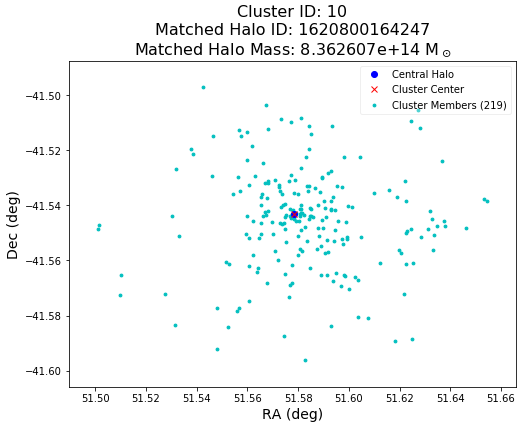

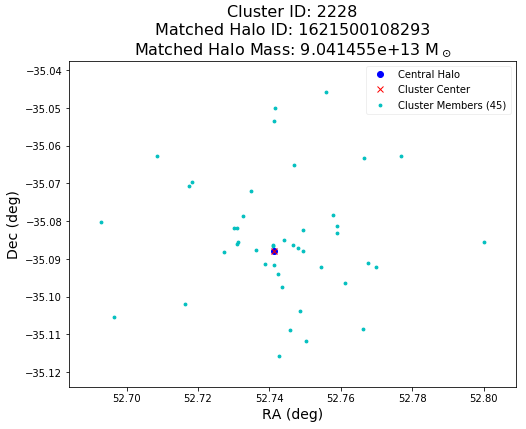

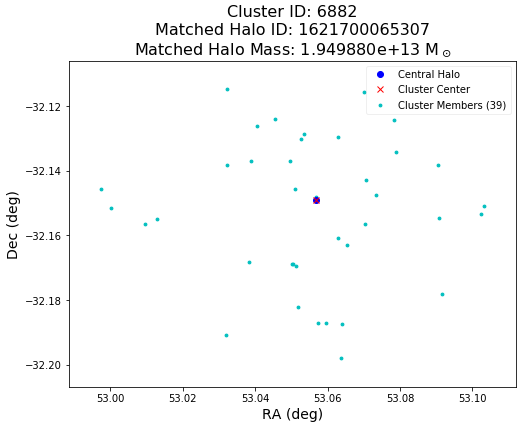

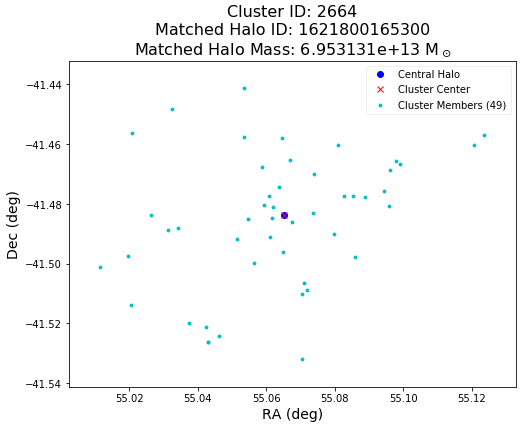

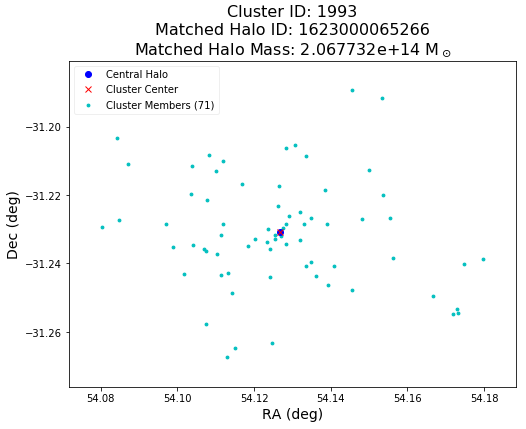

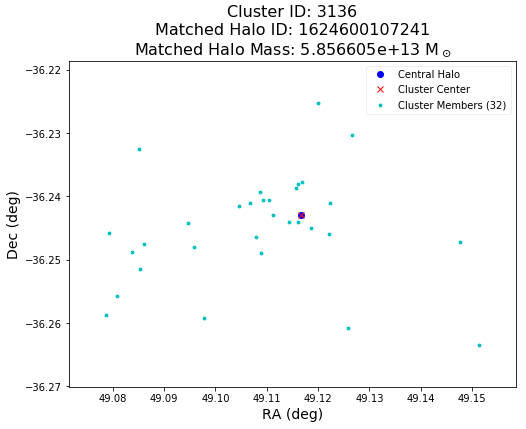

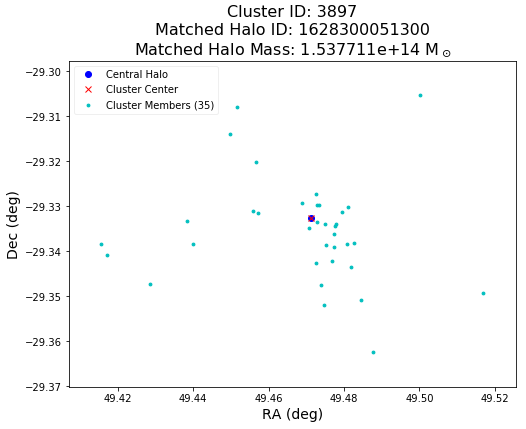

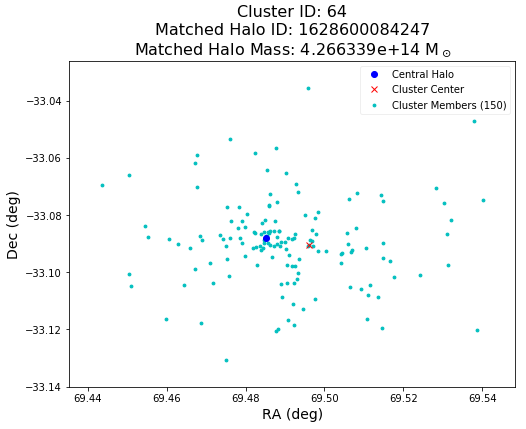

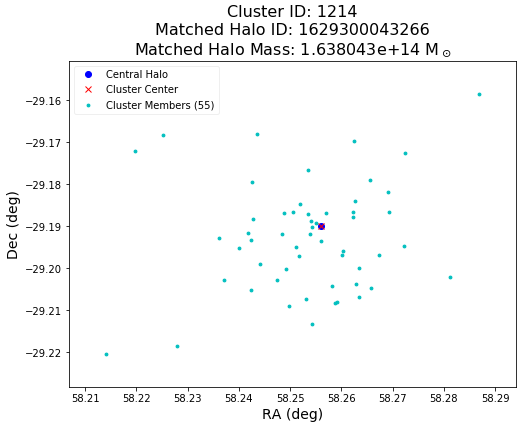

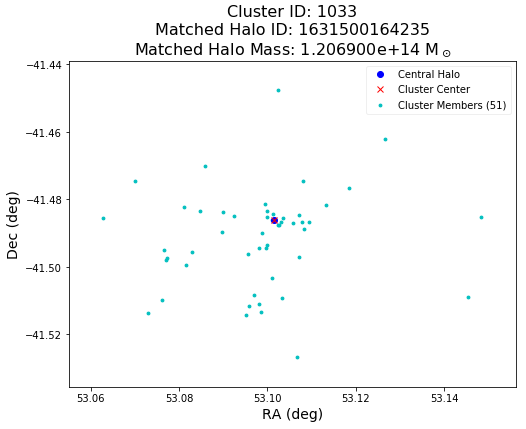

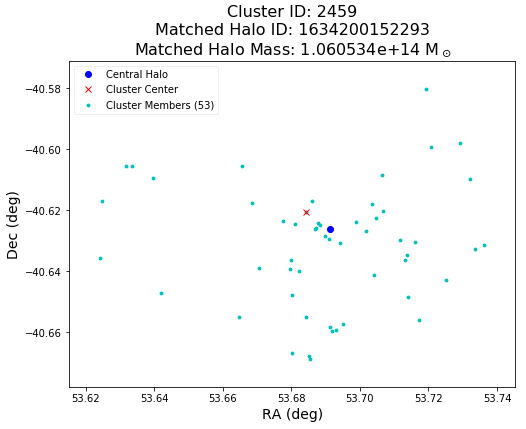

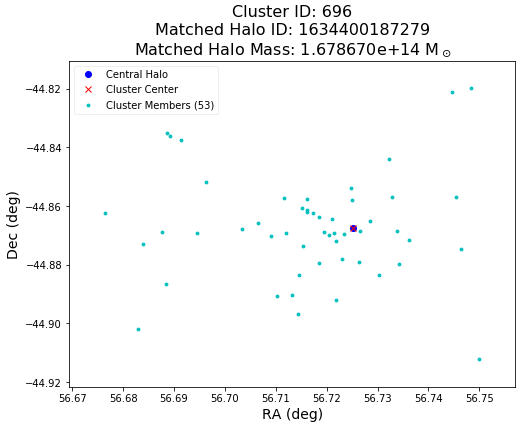

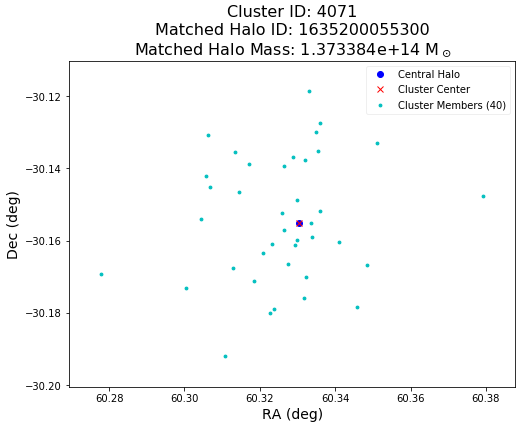

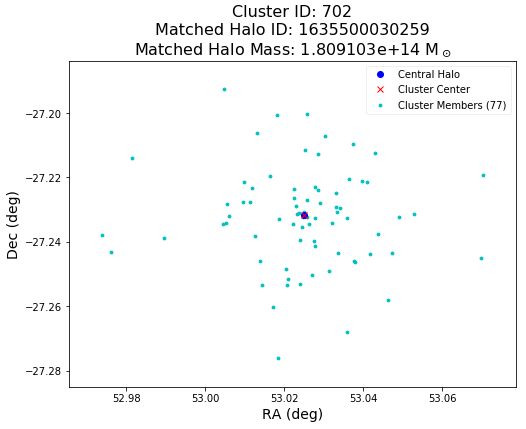

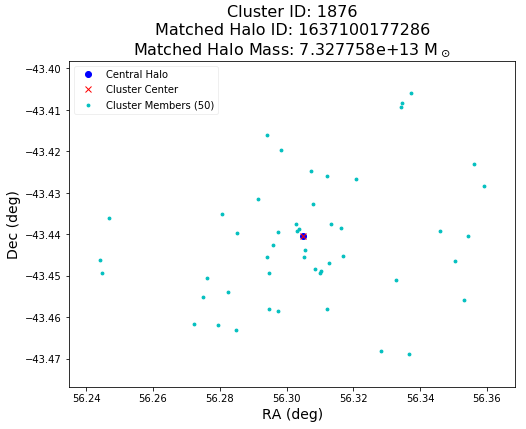

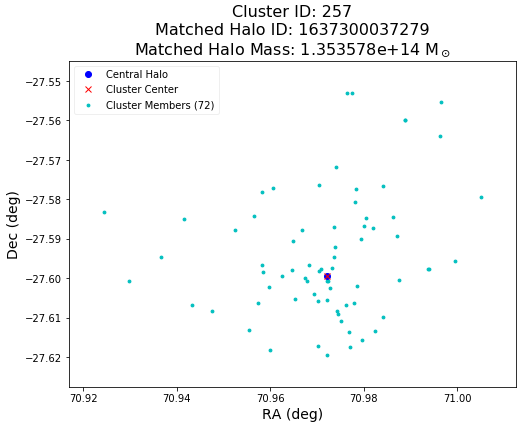

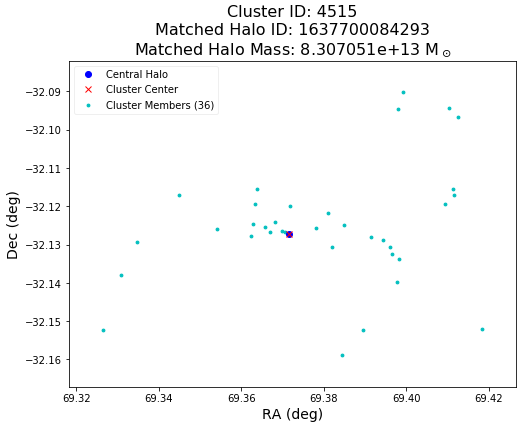

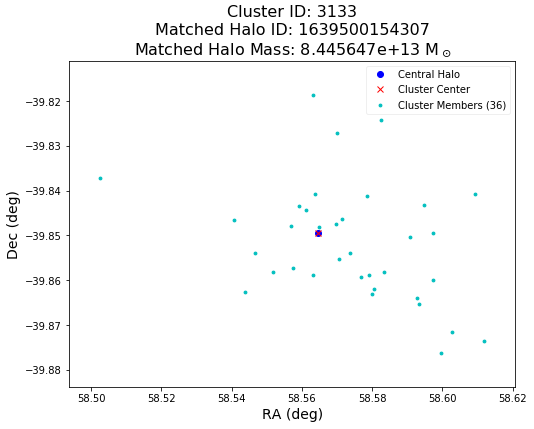

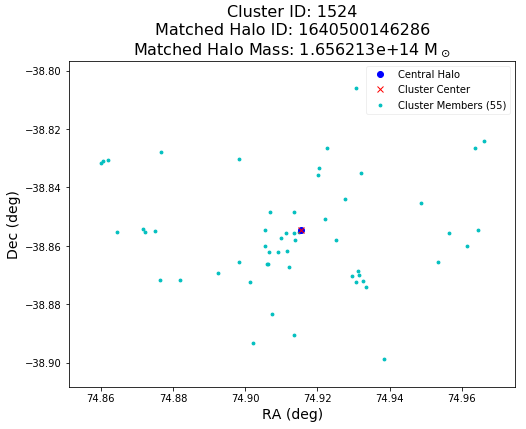

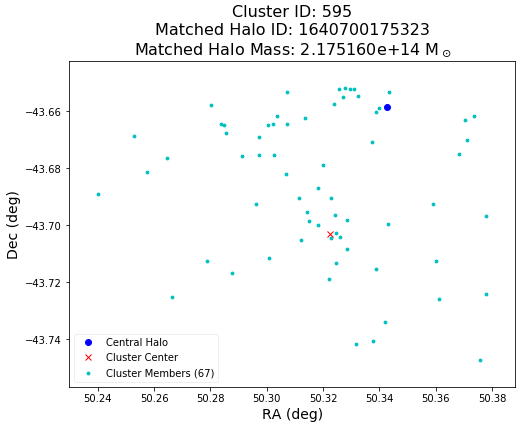

In [6]:
# without using delta RA and Dec
print("From our table, we are plotting indices {} through {}.".format(lbound, hbound))

for i, cluster in enumerate(redM_table):
    
    # plot only if i falls into the range
    if i >= lbound and i <= hbound:

        # gather member data for the cluster
        mem_ind = np.where(mem_table['cluster_id_member'] == cluster['cluster_id'])
        members = mem_table[mem_ind]
        
        # gather data for the matched halo
        halo_index = np.where(halos_table['matching_id'] == cluster['matching_id'])
        halo = halos_table[halo_index]
        
        # plot
        plt.figure(figsize=(8,6))
        plt.scatter(members['ra_member']
                    , members['dec_member']
                    , s = 8
                    , c = 'c'
                    , label='Cluster Members ({})'.format(len(members))
                   )
        plt.plot(halo['ra']
                 , halo['dec']
                 , 'ob'
                 , label='Central Halo'
                )
        plt.plot(cluster['ra']
                 , cluster['dec']
                 , 'xr'
                 , label='Cluster Center'
                )
        plt.legend(loc='best', framealpha=0.3)
        plt.xlabel(r'RA (deg)', fontsize=14)
        plt.ylabel(r'Dec (deg)', fontsize=14)
        plt.title(r'''Cluster ID: {}
Matched Halo ID: {}
Matched Halo Mass: {:2e} $\rm M_\odot$'''.format(cluster['cluster_id']
                                                 , halo['halo_id'][0]
                                                 , halo['halo_mass'][0])
                  , fontsize=16)
plt.show()

From our table, we are plotting indices 3001 through 3020.


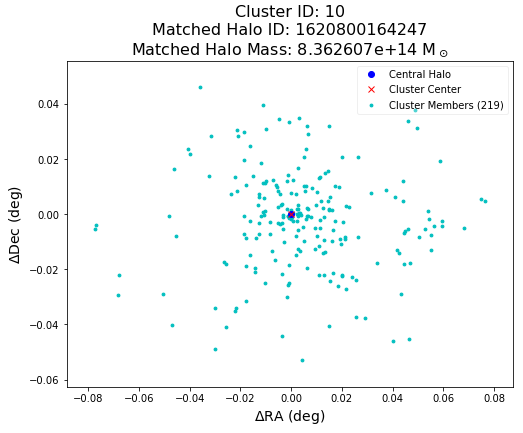

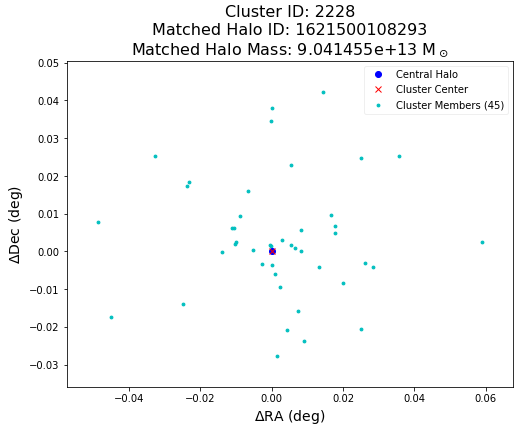

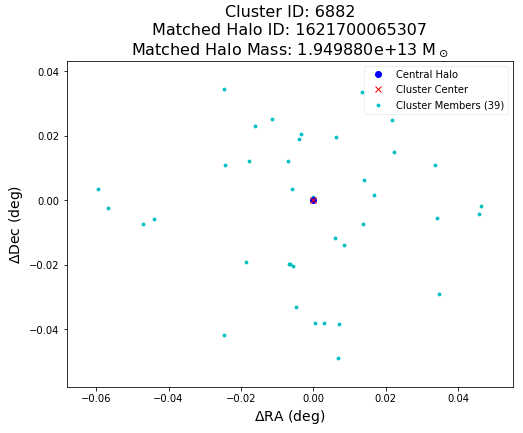

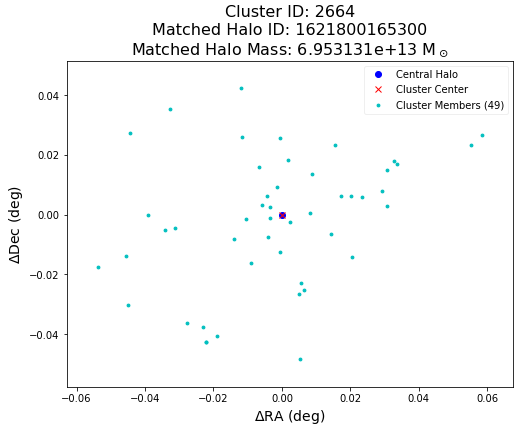

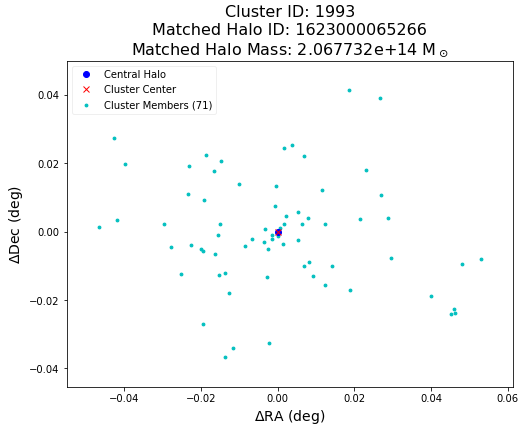

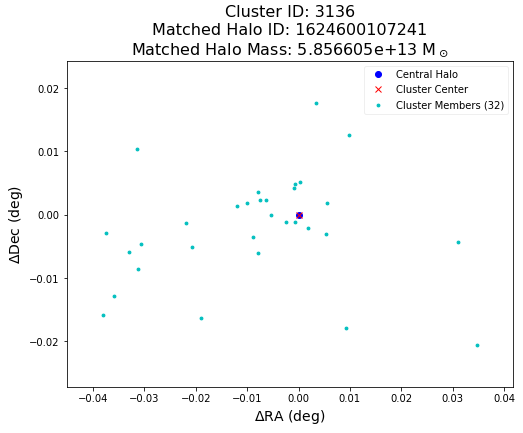

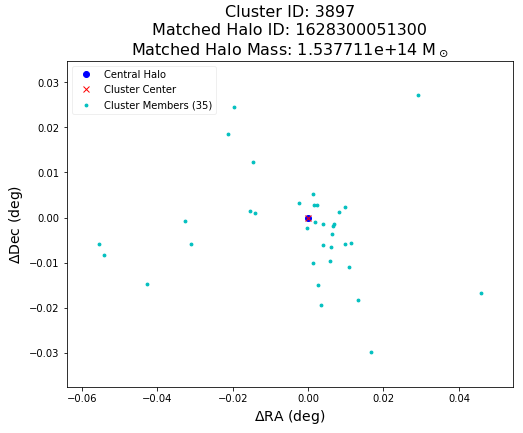

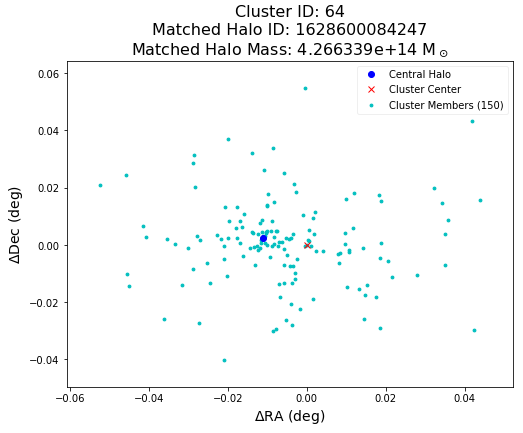

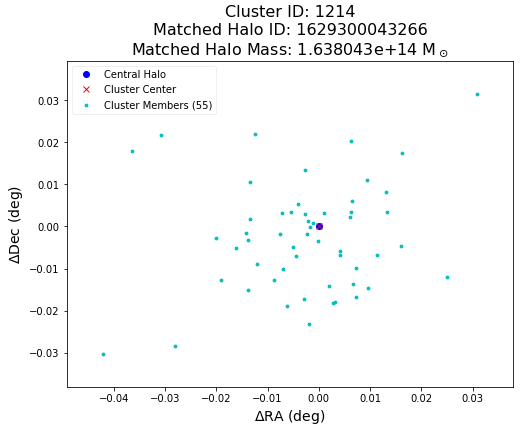

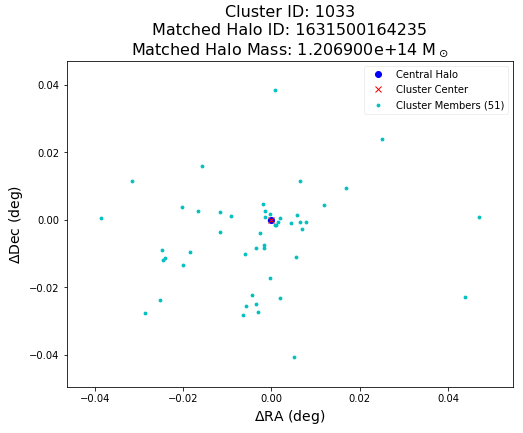

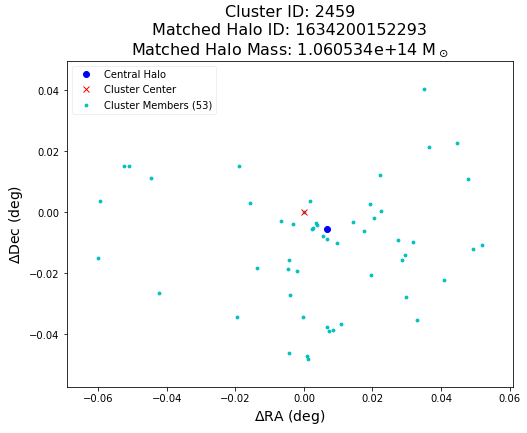

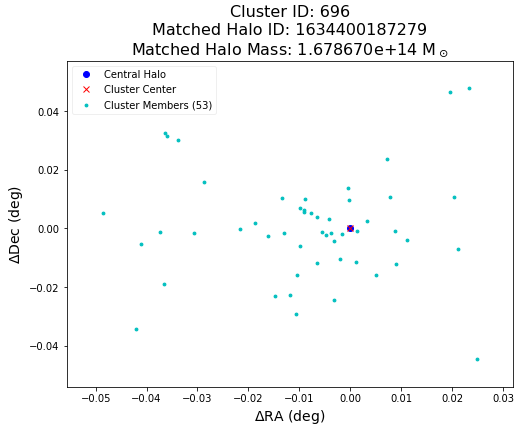

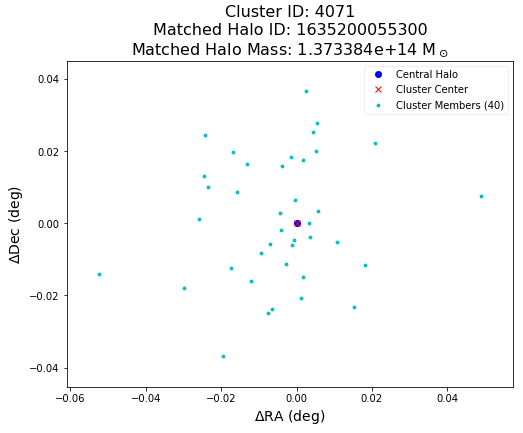

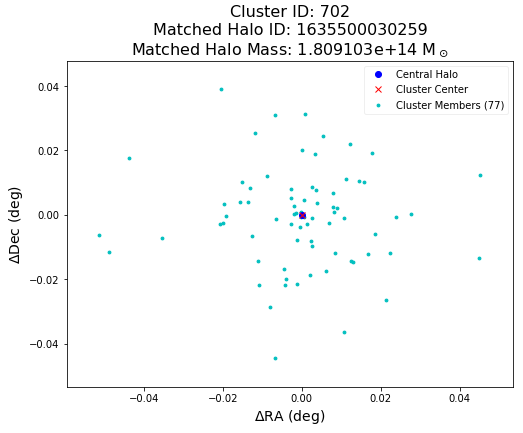

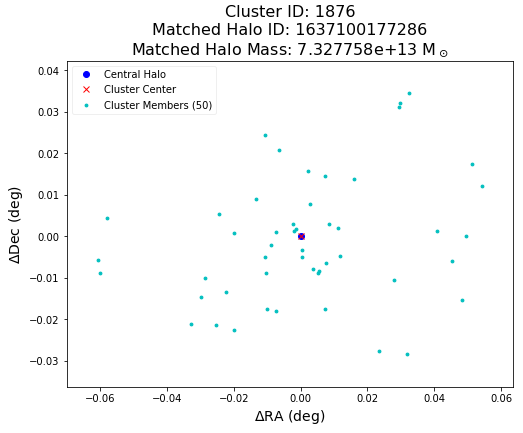

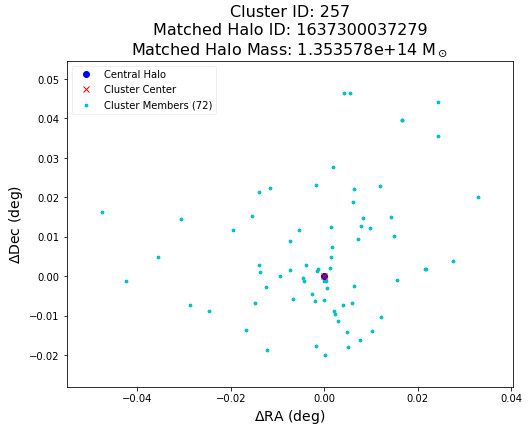

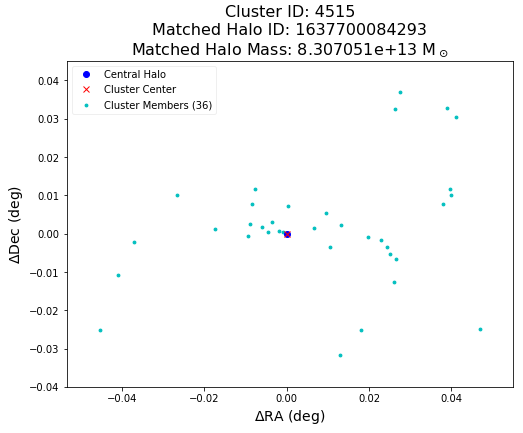

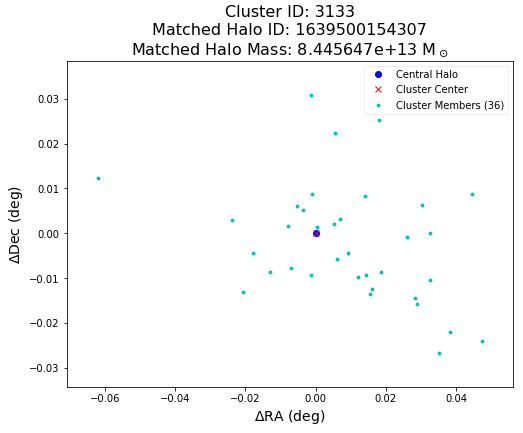

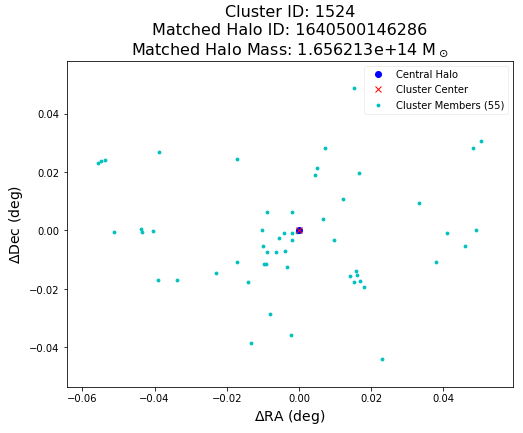

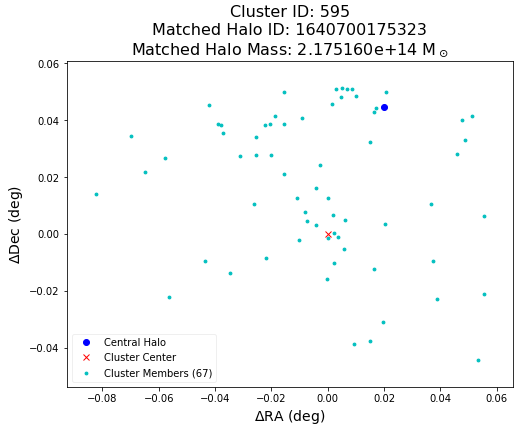

In [346]:
# with delta RA and Dec
print("From our table, we are plotting indices {} through {}.".format(lbound, hbound))

for i, cluster in enumerate(redM_table):
    
    # plot only if i falls into the range
    if i >= lbound and i <= hbound:
        
        # gather cluster data
        cluster_deltara = cluster['ra'] - cluster['ra']
        cluster_deltadec = cluster['dec'] - cluster['dec']
        
        # gather member data for the cluster
        mem_ind = np.where(mem_table['cluster_id_member'] == cluster['cluster_id'])
        members = mem_table[mem_ind]
        mem_deltara = members['ra_member'] - cluster['ra']
        mem_deltadec = members['dec_member'] - cluster['dec']
        
        # gather data for the matched halo
        halo_index = np.where(halos_table['matching_id'] == cluster['matching_id'])
        halo = halos_table[halo_index]
        halo_deltara = halo['ra'] - cluster['ra']
        halo_deltadec = halo['dec'] - cluster['dec']
        
        # plot
        plt.figure(figsize=(8,6))
        plt.scatter(mem_deltara
                    , mem_deltadec
                    , s = 8
                    , c = 'c'
                    , label='Cluster Members ({})'.format(len(members))
                   )
        plt.plot(halo_deltara
                 , halo_deltadec
                 , 'ob'
                 , label='Central Halo'
                )
        plt.plot(cluster_deltara
                 , cluster_deltadec
                 , 'xr'
                 , label='Cluster Center'
                )
        plt.legend(loc='best', framealpha=0.3)
        plt.xlabel(r'$\Delta$RA (deg)', fontsize=14)
        plt.ylabel(r'$\Delta$Dec (deg)', fontsize=14)
        plt.title(r'''Cluster ID: {}
Matched Halo ID: {}
Matched Halo Mass: {:2e} $\rm M_\odot$'''.format(cluster['cluster_id']
                                                 , halo['halo_id'][0]
                                                 , halo['halo_mass'][0])
                  , fontsize=16)
plt.show()

In [12]:
redM_table[np.where(redM_table['cluster_id'] == 595)]

scaleval,ra_cen_0,ra_cen_3,redshift,p_cen_4,p_cen_1,dec_cen_0,dec_cen_4,id_cen_2,redshift_err,redshift_true_cg,ra_cen_2,dec_cen_2,p_cen_0,p_cen_2,id_cen_3,dec_cen_3,p_cen_3,ra,richness,ra_cen_4,dec_cen_1,ra_cen_1,dec,richness_err,id_cen_1,cluster_id,id_cen_0,id_cen_4,maskfrac,centered_flag,matching_id,R_lambda,R_lambda_err
float32,float64,float64,float32,float32,float32,float64,float64,int64,float32,float32,float64,float64,float32,float32,int64,float64,float32,float64,float32,float64,float64,float64,float64,float32,int64,int32,int64,int64,float32,int64,int64,float32,float32
0.99992347,50.3224826025342,50.328434060487645,0.51303416,6.2833305e-07,0.49035424,-43.70300693873144,-43.70511363101038,10937958631,0.004418829,0.517413,50.34266114356587,-43.658288650637026,0.5064162,0.0029726655,10937951491,-43.70828964323498,0.0002562906,50.3224826025342,52.115204,50.312248141205856,-43.69979377898137,50.31833039551705,-43.70300693873144,2.6553018,10937940161,595,10937942512,10937940246,0.0,0,3773,0.87779456,0.008944835


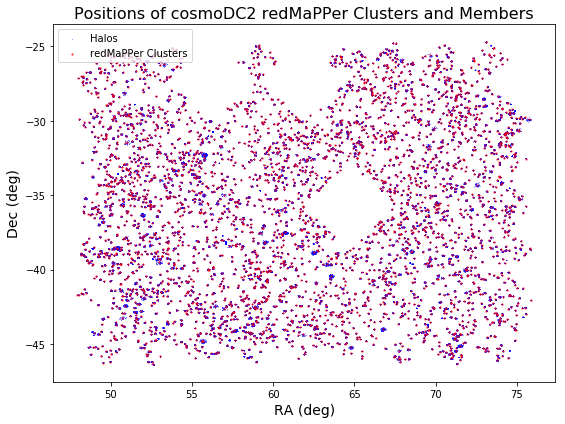

In [24]:
# Scatter plot of all cluster and member equatorial coordinates
plt.figure(figsize=(8,6))
plt.scatter(mem_table['ra_member'], mem_table['dec_member'], c='b', marker='.', s=2, linewidth=0.0, alpha=0.5, label='Halos')
plt.scatter(redM_table['ra'], redM_table['dec'], c='r', s=5, alpha=0.75, marker='o',linewidth=0.0, label='redMaPPer Clusters')

plt.xlabel('RA (deg)', fontsize=14); plt.ylabel('Dec (deg)', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.title('Positions of cosmoDC2 redMaPPer Clusters and Members', fontsize=16)
plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

In [68]:
# test 3D plotting
from mpl_toolkits import mplot3d

57
56


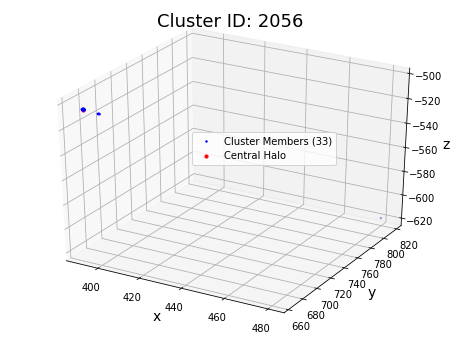

In [99]:
i = 0
ID = redM_table['cluster_id'][i]
mem_3d_ind = np.where(mem_table['cluster_id_member'] == ID)
mem_3d_data = mem_table[mem_3d_ind]
no_wrong_ztrue = np.where(mem_3d_data['redshift_true_member'] != -1.0)
mem_z3d_data = mem_3d_data[no_wrong_ztrue]
mem_p_ind = np.where(mem_z3d_data['p_member'] > 0.75)
mem_p3d_data = mem_z3d_data[mem_p_ind]
print(len(mem_3d_data))
print(len(mem_z3d_data))

mem_xdata = mem_p3d_data['x_member']
mem_ydata = mem_p3d_data['y_member']
mem_zdata = mem_p3d_data['z_member']

halo = halos_table[i]
halo_x = halo['position_x']
halo_y = halo['position_y']
halo_z = halo['position_z']

plt.figure(figsize=(8,6))

ax1 = plt.axes(projection='3d')
ax1.scatter3D(mem_xdata
              , mem_ydata
              , mem_zdata
              , c='b'
              , s=2
              , label='Cluster Members ({})'.format(len(mem_p3d_data))
             )
ax1.scatter3D(halo_x
              , halo_y
              , halo_z
              , c='r'
              , s=10
              , label='Central Halo'
             )

ax1.set_title('Cluster ID: {}'.format(ID), fontsize=18)
ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14)
ax1.set_zlabel('z', fontsize=14)

'''ax1.set_xlim(np.min(mem_table['x_member']), np.max(mem_table['x_member'] + 50))
ax1.set_ylim(np.min(mem_table['y_member']), np.max(mem_table['y_member'] + 50))
ax1.set_zlim(np.min(mem_table['z_member']), np.max(mem_table['z_member'] + 50))'''
#print(np.max(mem_ydata))

# https://stackoverflow.com/questions/23238041/move-and-resize-legends-box-in-matplotlib
legend = plt.legend(loc='lower center')
plt.draw()

bb = legend.get_bbox_to_anchor().inverse_transformed(ax1.transAxes)

# change to location of the legend 
xOffset = 0.075
yOffset = 0.5
bb.x0 += xOffset
bb.x1 += xOffset
bb.y0 += yOffset
bb.y1 += yOffset
legend.set_bbox_to_anchor(bb, transform = ax1.transAxes)

plt.show()

In [104]:
# these next two will be comparing our plotted data to that data in the original member table
mem_z3d_data['redshift_true_member', 'redshift_member']

redshift_true_member,redshift_member
float32,float64
0.26116854,0.26116854820115476
0.30063024,0.3006302284741278
0.33297613,0.33297614319456903
0.33458823,0.3345882319541138
0.3346488,0.334648801527321
0.3339224,0.3339223868194172
0.3335297,0.3335297109231816
0.33245438,0.33245439019600886
0.33172676,0.33172675372889016


In [102]:
print(ID)
mem_z3d_ind = np.where(filtered_mem_data['cluster_id_member'] == ID)

no_wrong_ztrue = np.where(filtered_mem_data['redshift_true_member'][mem_z3d_ind] != -1.0)

ztrue_cluster_mem = filtered_mem_data['redshift_true_member'][mem_z3d_ind][no_wrong_ztrue]

max_min = [np.where(ztrue_cluster_mem == np.min(ztrue_cluster_mem))[0][0]
               , np.where(ztrue_cluster_mem == np.max(ztrue_cluster_mem))[0][0]]
ztrue_cluster_mem[max_min]

2056


0.26116854
0.41605604


In [59]:
counter = 0
for i, member in enumerate(mem_table):
    diff = abs(member['redshift_true_member'] - member['redshift_member'])
    if diff > 1e-5 and abs(member['redshift_true_member'] + 1.0) > 1e-5:
        counter += 1
        print(i)
        
print("----------------------\nTotal disparities:", counter)

----------------------
Total disparities: 0


In [56]:
mem_table['redshift_true_member', 'redshift_member'][5504]

redshift_true_member,redshift_member
float32,float64
-1.0,0.44631049833398895


In [19]:
counter = 0
for i, halo in enumerate(halos_table):
    diff = abs(halo['redshift'] - halo['test_dask_redshift'])
    if diff > 0:
        counter += 1
        
print(counter)

0


In [17]:
halos_table

ra,halo_id,redshift,dec,halo_mass,galaxy_id,matching_id,filtered_halo_ind,ellipticity_1_true,ellipticity_2_true,ellipticity_true,size_true,size_minor_true,position_angle_true,position_x,position_y,position_z,test_dask_redshift
float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64
59.51824985398962,300081373,0.33297614319456903,-33.158979952317786,168475267129690.16,5062612918,1214,87,-0.1376046269399755,-0.09864539815934402,0.16931021,1.9183539,1.362818,107.81790751987383,392.04388427734375,666.0264892578125,-504.90789794921875,0.33297614319456903
63.563618571508925,700156401,0.24034691441733247,-40.402946189791535,401753499884529.6,9750040774,2741,206,0.06446585846240406,0.06727491717931544,0.09317597,4.105088,3.4053006,23.110755565149724,233.65869140625,469.97564697265625,-446.74151611328125,0.24034691441733247
55.49421354590657,800109421,0.16321240254147318,-35.543228691028624,158468012233915.5,6812514950,1550,225,0.049026540090104105,-0.007930251016427152,0.049663775,5.204635,4.712131,175.40587397963625,220.47140502929688,320.7092590332031,-278.0568542480469,0.16321240254147318
53.50508584825039,1300152293,0.6906776096666896,-38.93446229743254,88882695280495.78,9500877685,2547,361,0.3253650581451051,0.04374108966838368,0.3282921,0.94860286,0.47970173,3.8283815332234328,816.408935546875,1102.8782958984375,-1108.254638671875,0.6906776096666896
70.97779302410089,1700047272,0.7992598130220308,-27.986615732111254,277497161179943.7,2938839318,749,434,-0.2521596883862891,-0.14769802434503324,0.29223144,2.4477744,1.3406714,105.179437755302,576.874755859375,1674.132080078125,-940.80126953125,0.7992598130220308
58.90146603180482,1700178432,0.13984173425220847,-42.499555259856784,298075716247436.6,11125008925,2599,452,0.015787843515630395,-0.03277984346730134,0.036383707,3.2850926,3.054437,147.8584927829831,154.52320861816406,256.1650085449219,-274.1407165527344,0.13984173425220847
74.4050818122735,2200183253,0.952321823135351,-43.33793210737625,86824591659988.73,11439412584,3313,583,0.03128298630445316,0.04131941440559253,0.051825855,0.72289574,0.65165824,26.435292775406737,443.4544372558594,1588.867431640625,-1555.9656982421875,0.952321823135351
67.20267010751463,2600098355,0.3755895850691817,-34.76310738975409,287691564738704.25,6125184983,1292,677,0.10036460937235081,-0.25686646780886296,0.27577788,2.3974373,1.3609557,145.6709594752213,332.4804992675781,791.0972900390625,-595.5177001953125,0.3755895850691817
51.02391340590549,3200064453,0.07971474503442022,-31.450309076864762,102827675013408.45,4000001799,1007,827,-0.0007039687898263917,-0.0014132992059355102,0.0015789195,4.811998,4.7968264,121.76097993105878,127.34683990478516,157.3885498046875,-123.82939147949219,0.07971474503442022


In [361]:
test_uniq_id = np.unique(mem_table['cluster_id_member'])
print(len(test_uniq_id))

3895
